# PA Case: "Hospital Readmission sample solution"

I translated approximately to Python from the official sample solution, in R, from SOA. Output and plots can be compared to a [published markdown](exam-pa-hospital-readmission-sample-sol.pdf) of the [original R solution from SOA](https://cdn-files.soa.org/web/exam-pa-hospital-readmission-sample-sol.Rmd)

Some notable differences:
- Pandas dataframes and series provided some similar functionality to R's data.frame
- The patsy module allowed flexible R-like formulas and design matrices
- I could not get python ggplot module to work consistently, so had to write verbose seaborn and matplotlib code that was still far from matching R's ggplot2 visuals
- statsmodels (and specifically statsmodels.formula.api.glm) generated much of R's generalized regression results.
- convenient functions like R's stepAIC had to implemented from scratch in Python.
- below are some similar pairs of commands

## R to Python commands:
createDataPartition - train_test_split                                                                        
confusionMatrix - sklearn.metrics.confusion_matrix, classification_report                                     
roc - sklearn.metrics.roc_curve,                                                                              
auc - sklearn.metrics.auc                                                                                     
str - info()                                                                                                  
summary - describe()                                                                                          
table - Series.value_counts(), pd.crosstab()                                                                  
factor - Series.astype('category'), pd.categorize()                                                           
dummyVars - pd.get_dummies(), OneHotEncode() -- for scaleability                                              
geom_hist - sns.distplot(kde=False, hist=True, color=, bins=)                                                 
geom_point - sns.scatterplot(x=, y=, hue=, data=)                                                             
facet_wrap - sns.FacetGrid 

In [2]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_curve, auc

from patsy import dmatrices, dmatrix
from statsmodels.formula.api import glm
import statsmodels.api as sm
import statsmodels.genmod.families as smf

def summary(df):
    '''                                                                                                         
    describe() if numeric, else value_counts()                                                                  
    '''
    df = DataFrame(df)
    for c in df.columns:
        if df[c].dtype in [int, float]:
            print(df[c].describe())
        else:
            print(df[c].value_counts())
        print()

def relevel(s, ref=None):
    '''                                                                                                         
    convert to category type and relevel ref as first level                                                     
    '''
    cats = list(s.value_counts(sort=True, ascending=False).index)
    if ref: ref = cats.index(ref)
    else: ref = 0      # default first level is most frequent                                                   
    swap = cats[ref]
    cats[ref] = cats[0]
    cats[0] = swap
    return s.astype(pd.api.types.CategoricalDtype(categories=cats, ordered=True))


This chunk reads in the data, relevels factors, and prints a summary.

```{r}
# Loading data
readmission <- read.csv(file="readmission.csv")

vars <- colnames(readmission)[c(2,3,5,9)] #variables to relevel
for (i in vars){
  table <- as.data.frame(table(readmission[,i]))
  max <- which.max(table[,2])
  level.name <- as.character(table[max,1])
  readmission[,i] <- relevel(readmission[,i], ref = level.name)
}
summary(readmission) 
```

In [3]:
readmission = pd.read_csv("readmission.csv")
readmission.columns = [w.replace('.','_') for w in readmission.columns]  # replace "."                          

vars = list(readmission.columns[np.array([2,3,5,9]) - 1])
for i in vars:
    readmission[i] = relevel(readmission[i])
summary(readmission)


count    66782.000000
mean         0.125917
std          0.331758
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Readmission_Status, dtype: float64

F    38011
M    28771
Name: Gender, dtype: int64

White       56124
Black        7099
Others       2273
Hispanic     1286
Name: Race, dtype: int64

count    66782.000000
mean         0.508281
std          0.817415
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: ER, dtype: float64

MED        35771
SURG       30447
UNGROUP      564
Name: DRG_Class, dtype: int64

count    66782.000000
mean         6.693420
std          5.698282
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         36.000000
Name: LOS, dtype: float64

count    66782.000000
mean        73.636309
std         13.337235
min         24.000000
25%         67.000000
50%         75.000000
75%         83.

## Task 1
I have elected to make a table for ER and histograms for the other three variables.

```{r}
library(ggplot2)
table(readmission$ER)
ggplot(readmission,aes(x=LOS))+geom_histogram()
ggplot(readmission,aes(x=Age))+geom_histogram()
ggplot(readmission,aes(x=HCC.Riskscore))+geom_histogram()

```

0    43086
1    16280
2     5286
3     1572
4      438
5      105
6       10
7        3
9        2
Name: ER, dtype: int64


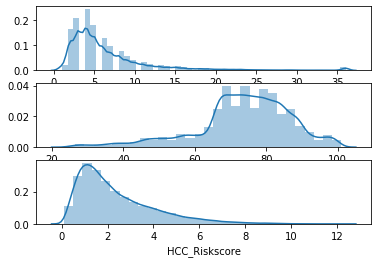

In [6]:
    print(readmission['ER'].value_counts())
    plt.subplot(3,1,1)
    sns.distplot(readmission['LOS'])
    plt.subplot(3,1,2)
    sns.distplot(readmission['Age'], bins=30)
    #plt.hist(readmission['Age'], bins=30)                  # equivalent matplotlib hist                        
    plt.subplot(3,1,3)
    sns.distplot(readmission['HCC_Riskscore'], bins=30)
    #readmission['HCC_Riskscore'].hist(bins=30,grid=False)  # equivalent pandas hist                            


I will use log transformations of the LOS and HCC.Riskscore variables. I also create an indicator variables for those under age 65. The following chunk does these.

```{r}
#two log transforms and removal of original variables
readmission$logLOS <- log(readmission$LOS)
readmission$logRiskscore <- log(readmission$HCC.Riskscore)
readmission$LOS <- NULL
readmission$HCC.Riskscore <- NULL
readmission$Under65 <- ifelse(readmission$Age < 65, 1, 0)
summary(readmission)
```

In [7]:
readmission['logLOS'] = np.log(readmission['LOS'])
readmission['logRiskscore'] = np.log(readmission['HCC_Riskscore'])
readmission = readmission.drop(columns=['LOS', 'HCC_Riskscore'])
readmission['Under65'] = readmission['Age'] < 65
summary(readmission)


count    66782.000000
mean         0.125917
std          0.331758
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Readmission_Status, dtype: float64

F    38011
M    28771
Name: Gender, dtype: int64

White       56124
Black        7099
Others       2273
Hispanic     1286
Name: Race, dtype: int64

count    66782.000000
mean         0.508281
std          0.817415
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: ER, dtype: float64

MED        35771
SURG       30447
UNGROUP      564
Name: DRG_Class, dtype: int64

count    66782.000000
mean        73.636309
std         13.337235
min         24.000000
25%         67.000000
50%         75.000000
75%         83.000000
max        101.000000
Name: Age, dtype: float64

MedicalMCC.CC    18110
SurgMCC.CC       15468
MedicalNoC       12310
SurgNoC          11549
Other             9345
Name: DRG_Complication, dtype: i

## Task 2
This chunk creates a tabular view of the two variables.

```{r}
table(readmission$DRG.Class,readmission$DRG.Complication)

```

Six items will be deleted and the two existing variables recoded as a single factor variable. The following code does that.

```{r}
readmission.new <- readmission #preserve the original data until the work can be checked
readmission.new <- readmission.new[!(readmission.new$DRG.Complication=="MedicalMCC.CC" &  readmission.new$DRG.Class=="SURG"),]
readmission.new$DRG <- ifelse(readmission.new$DRG.Complication=="MedicalMCC.CC","Med.C",
ifelse(readmission.new$DRG.Complication=="MedicalNoC","Med.NoC",
ifelse(readmission.new$DRG.Complication=="SurgMCC.CC","Surg.C",
ifelse(readmission.new$DRG.Complication=="SurgNoC","Surg.NoC",
ifelse(readmission.new$DRG.Class=="UNGROUP","UNGROUP",
ifelse(readmission.new$DRG.Complication=="Other"&readmission.new$DRG.Class=="MED","OtherMED","OtherSURG"))))))
readmission.new$DRG <- as.factor(readmission.new$DRG)
table(readmission.new$DRG)
readmission.new$DRG.Class <- NULL
readmission.new$DRG.Complication <- NULL

```

Relevel the new variable.

```{r}
table <- as.data.frame(table(readmission.new[,"DRG"]))
  max <- which.max(table[,2])
  level.name <- as.character(table[max,1])
  readmission.new[,"DRG"] <- relevel(readmission.new[,"DRG"], ref = level.name)
table(readmission.new$DRG)
```


Accept the new dataframe by renaming it back to readmission.

```{r}
readmission <- readmission.new
readmission.new <- NULL
summary(readmission)
```

In [8]:
# Task 2                                                                                                        
print(pd.crosstab(index=readmission['DRG_Class'],columns=readmission['DRG_Complication']))
DRG_Class = readmission['DRG_Class'].cat.categories[readmission['DRG_Class'].cat.codes]
DRG_Complication = readmission['DRG_Complication'].cat.categories[readmission['DRG_Complication'].cat.codes]
keep = np.logical_not((DRG_Complication=="MedicalMCC.CC") & (DRG_Class=="SURG"))
readmission_new = readmission[keep].copy()
DRG_Class = DRG_Class[keep]
DRG_Complication = DRG_Complication[keep]

readmission_new.loc[DRG_Complication == "Other", 'DRG' ] = 'OtherSURG'  # reverse order of nested ifelse's      
readmission_new.loc[(DRG_Complication == "Other") & (DRG_Class == "MED"), 'DRG' ] = 'OtherMED'
readmission_new.loc[DRG_Class == "UNGROUP", 'DRG'] = 'UNGROUP'
readmission_new.loc[DRG_Complication == "SurgNoC", 'DRG'] = "Surg_NoC"
readmission_new.loc[DRG_Complication == "SurgMCC.CC", 'DRG'] = "Surg_C"
readmission_new.loc[DRG_Complication == "MedicalNoC", 'DRG'] = "Med_NoC"
readmission_new.loc[DRG_Complication == "MedicalMCC.CC",'DRG'] = "Med_C"

readmission_new = readmission_new.drop(columns = ['DRG_Class','DRG_Complication'])
readmission_new['DRG'] = readmission_new['DRG'].astype("category")
readmission = readmission_new
summary(readmission)


DRG_Complication  MedicalMCC.CC  SurgMCC.CC  MedicalNoC  SurgNoC  Other
DRG_Class                                                              
MED                       18104           0       12310        0   5357
SURG                          6       15468           0    11549   3424
UNGROUP                       0           0           0        0    564
count    66776.000000
mean         0.125928
std          0.331771
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Readmission_Status, dtype: float64

F    38005
M    28771
Name: Gender, dtype: int64

White       56120
Black        7097
Others       2273
Hispanic     1286
Name: Race, dtype: int64

count    66776.000000
mean         0.508296
std          0.817420
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: ER, dtype: float64

count    66776.000000
mean        73.637669
std         13.336339
min   

## Task 3
This code performs cluster analysis for from 1 to 12 clusters and constructs an elbow plot.

```{r}
nstart.val <- 20
cluster_vars <- readmission[c('logLOS','Age')]
for(i in 1:ncol(cluster_vars)){
  cluster_vars[,i] <- scale(cluster_vars[,i])
}
km1 <- kmeans(cluster_vars,centers=1,nstart=nstart.val)
km2 <- kmeans(cluster_vars,centers=2,nstart=nstart.val)
km3 <- kmeans(cluster_vars,centers=3,nstart=nstart.val)
km4 <- kmeans(cluster_vars,centers=4,nstart=nstart.val)
km5 <- kmeans(cluster_vars,centers=5,nstart=nstart.val)
km6 <- kmeans(cluster_vars,centers=6,nstart=nstart.val)
km7 <- kmeans(cluster_vars,centers=7,nstart=nstart.val)
km8 <- kmeans(cluster_vars,centers=8,nstart=nstart.val)
km9 <- kmeans(cluster_vars,centers=9,nstart=nstart.val)
km10 <- kmeans(cluster_vars,centers=10,nstart=nstart.val)
km11 <- kmeans(cluster_vars,centers=11,nstart=nstart.val)
km12 <- kmeans(cluster_vars,centers=12,nstart=nstart.val)

var.exp <- data.frame(k = c(1:12),
                      bss_tss = c(km1$betweenss/km1$totss,
                                  km2$betweenss/km2$totss,
                                  km3$betweenss/km3$totss,
                                  km4$betweenss/km4$totss,
                                  km5$betweenss/km5$totss,
                                  km6$betweenss/km6$totss,
                                  km7$betweenss/km7$totss,
                                  km8$betweenss/km8$totss,
                                  km9$betweenss/km9$totss,
                                  km10$betweenss/km10$totss,
                                  km11$betweenss/km11$totss,
                                  km12$betweenss/km12$totss))

ggplot(var.exp,aes(x=k,y=bss_tss))+geom_point()


```


1 133551.99999999997
2 90939.87008663375
3 58919.71016473408
4 46847.49474862287
5 37698.519024369445
6 32200.3120082694
7 28560.88151478924
8 24979.895722840032
9 22578.95811326782
10 20575.597030183806
11 19095.886224687973
12 17365.285925741664
     k   bss_tss
0    1  0.000000
1    2  0.319068
2    3  0.558826
3    4  0.649219
4    5  0.717724
5    6  0.758893
6    7  0.786144
7    8  0.812958
8    9  0.830935
9   10  0.845936
10  11  0.857015
11  12  0.869974


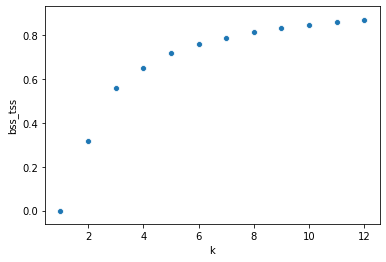

In [9]:
# Task 3: cluster                                                                                               
nstart_val = 20
cluster_vars = readmission[['logLOS','Age']].copy()
for c in cluster_vars.columns:
    cluster_vars[c] = scale(cluster_vars[c].astype('float'))
km = []
maxK = 12
for k in range(1,maxK+1):
    km.append(KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
                     n_clusters=k, n_init=nstart_val, precompute_distances='auto',
                     random_state=None, verbose=0))
    km[-1].fit(cluster_vars)
    print(k, km[-1].inertia_)
var_exp = DataFrame({'k' : [k.n_clusters for k in km],
                     'bss_tss': [1-(k.inertia_/km[0].inertia_) for k in km]})
print(var_exp)
sns.scatterplot(x='k', y='bss_tss', data=var_exp)


The following chunk creates the new variable based on 5 clusters.

```{r}
LOS_Age_Clust <- as.factor(km5$cluster) #This creates a new variable based on having 5 clusters.
cluster_vars$LOS_Age_Clust <- LOS_Age_Clust
ggplot(data = cluster_vars, aes(x = Age, y = logLOS, col = LOS_Age_Clust)) + geom_point() + theme(axis.text = element_blank(), legend.title = element_blank()) +ggtitle("Clustering with 5 groups")
```

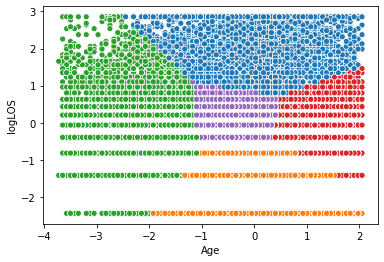

In [11]:
LOS_Age_Clust = Series(data=km[4].labels_, index=cluster_vars.index).astype('category')
cluster_vars['LOS_Age_Clust'] = LOS_Age_Clust
sns.scatterplot(x='Age', y='logLOS', hue='LOS_Age_Clust', data=cluster_vars,
                legend = False, palette=sns.color_palette(n_colors=5))

## Task 4

My first look is at ER and logRiskscore.

```{r}

ggplot(readmission,aes(x=factor(Readmission.Status),y=logRiskscore)) + geom_boxplot() +facet_wrap(~factor(ER))

```

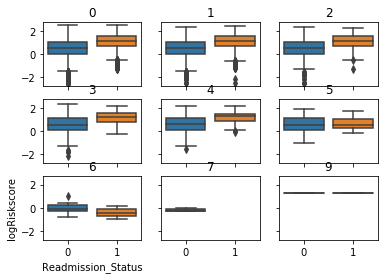

In [12]:
# Task 4                                                                                                        
# quick and dirty boxplot                                                                                       
#sns.boxplot(x="ER", hue="Readmission_Status", y="logRiskscore", data=readmission)

# sns.FacetGrid not work well with boxplot, hence...                                                            
cats = sorted(readmission['ER'].unique())
ncol = 3
fig, axes = plt.subplots(int(np.ceil(len(cats)/ncol)), ncol, sharey=True, sharex=True)
axes = axes.flatten()
for i in range(len(cats)):
    ax = sns.boxplot(x="Readmission_Status", y="logRiskscore",
                     data=readmission[readmission['ER'] == cats[i]],
                     orient='v', ax=axes[i])
    ax.set(xlabel='', ylabel='', title=str(cats[i]))
    if ax.is_first_col() and ax.is_last_row():
        ax.set(ylabel='logRiskscore')
        ax.set(xlabel='Readmission_Status')

Trying again with Race and Gender.

```{r}
ggplot(readmission,aes(Gender,fill=factor(Readmission.Status))) + geom_bar(position = "fill") +
  facet_wrap(~Race,ncol=2,scales="free")+scale_y_continuous()+ylab("percent")
```

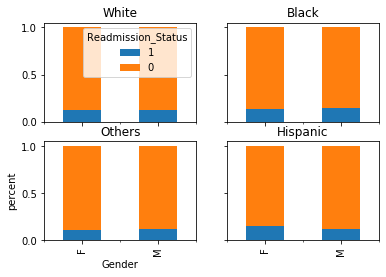

In [13]:
# Stacked percent bar chart                                                                                     
cats = readmission['Race'].cat.categories
ncol = 2
fig, axes = plt.subplots(int(np.ceil(len(cats)/ncol)), ncol, sharey=True, sharex=True)
axes = axes.flatten()
for i in range(len(cats)):
    f = readmission['Race'].cat.codes == i
    x = pd.crosstab(index=readmission['Readmission_Status'][f],
                    columns=readmission['Gender'][f])[::-1]   # reorder                                     
    y = x / x.sum()  # sum by column                                                                        
    ax = y.transpose().plot(kind='bar', stacked=True, ax=axes[i], legend=None)
    ax.set(xlabel='', ylabel='', title=str(cats[i]))
    if i == 0:
        ax.legend(loc=0, title='Readmission_Status')
    if ax.is_first_col() and ax.is_last_row():
        ax.set(ylabel='percent')
        ax.set(xlabel='Gender')

## Task 5

Before fitting a GLM, I will split the data into training and test sets.

```{r}
#Create train and test sets
library(caret)
set.seed(4321)
partition <- createDataPartition(readmission[,1], list = FALSE, p = .75) #The partition will stratify using variable 1 from the dataframe
train <- readmission[partition, ]
test <- readmission[-partition, ]

print("TRAIN")
mean(train$Readmission.Status)

print("TEST")
mean(test$Readmission.Status)

```

In [14]:
# Task 5                                                                                                        
train, test = train_test_split(readmission, stratify=readmission.iloc[:,0],
                               train_size = 0.75, test_size=0.25, random_state = 4321)
print('TRAIN', np.mean(train['Readmission_Status']))
print('TEST', np.mean(test['Readmission_Status']))

TRAIN 0.12593346911065853
TEST 0.1259135018569546


I will now run a glm using the binomial distribution and logit link and add the desired interaction.

```{r}
library(pROC)
glmlogit <- glm(Readmission.Status ~ . + Gender*Race, data=train, family = binomial(link="logit"))

summary(glmlogit)

predslogit <- predict(glmlogit,newdat=test,type="response")

roclogit <- roc(test$Readmission.Status,predslogit)

confusionMatrix(factor(1*(predslogit>.5)),factor(test$Readmission.Status))

plot(roclogit)

auc(roclogit)
```

Readmission_Status ~ Gender * Race + Race + logRiskscore + logLOS + Under65 + Gender + DRG + ER + Age
                 Generalized Linear Model Regression Results                  
Dep. Variable:     Readmission_Status   No. Observations:                50082
Model:                            GLM   Df Residuals:                    50063
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16955.
Date:                Sun, 08 Dec 2019   Deviance:                       33909.
Time:                        00:00:34   Pearson chi2:                 4.95e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------

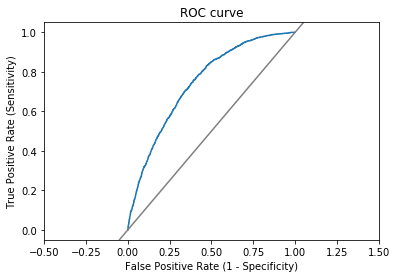

In [15]:
def plot_roc(fpr, tpr):
    plt.xlim([-0.50, 1.50])
    plt.ylim([-0.05, 1.05])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC curve')
    plt.plot([-.05, 1.05], [-.05, 1.05], color='grey', linestyle='-')

form = 'Readmission_Status ~ Gender * Race + ' + " + ".join(set(train.columns) - set(['Readmission_Status']))
print(form)

# binomial logit glm                                                                                            
glmlogit = glm(formula=form, data=train, family=smf.family.Binomial(smf.links.logit())).fit()
print(glmlogit.summary())

predslogit = glmlogit.predict(test)
fpr, tpr, _ = roc_curve(test['Readmission_Status'], predslogit)
print(auc(fpr, tpr))
print(confusion_matrix(test['Readmission_Status'], predslogit > 0.5))
print(classification_report(test['Readmission_Status'], predslogit > 0.5))
plot_roc(fpr, tpr)

The same code is now run with the probit link.

```{r}
library(pROC)
glmprobit <- glm(Readmission.Status ~ . + Gender*Race, data=train, family = binomial(link="probit"))

summary(glmprobit)

predsprobit <- predict(glmprobit,newdat=test,type="response")

rocprobit <- roc(test$Readmission.Status,predsprobit)

confusionMatrix(factor(1*(predsprobit>.5)),factor(test$Readmission.Status))

plot(rocprobit)

auc(rocprobit)
```

                 Generalized Linear Model Regression Results                  
Dep. Variable:     Readmission_Status   No. Observations:                50082
Model:                            GLM   Df Residuals:                    50063
Model Family:                Binomial   Df Model:                           18
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16948.
Date:                Sun, 08 Dec 2019   Deviance:                       33896.
Time:                        00:02:45   Pearson chi2:                 5.30e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

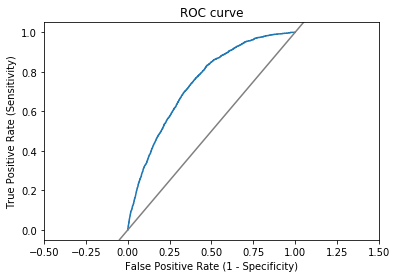

In [17]:
# binomial probit glm                                                                                           
glmprobit = glm(formula=form, data=train, family=smf.family.Binomial(smf.links.probit())).fit()
print(glmprobit.summary())

predsprobit = glmprobit.predict(test)
fpr, tpr, _ = roc_curve(test['Readmission_Status'], predsprobit)
print(auc(fpr, tpr))
print(confusion_matrix(test['Readmission_Status'], predsprobit > 0.5))
print(classification_report(test['Readmission_Status'], predsprobit > 0.5))
plot_roc(fpr, tpr)

## Task 6

A new dataframe is created that drops logLOS and Age and adds LOS_Age_Clust. It must then be partitioned.

```{r}
readmission.cluster <- readmission
readmission.cluster$Age <- NULL
readmission.cluster$logLOS <- NULL
readmission.cluster$LOS_Age_Clust <- LOS_Age_Clust
table(readmission.cluster$LOS_Age_Clust)
train.cluster <- readmission.cluster[partition, ]
test.cluster <- readmission.cluster[-partition, ]
```

This code reruns the probit regression using the cluster variable.

```{r}
library(pROC)
glmprobit.clust <- glm(Readmission.Status ~ . + Gender*Race, data=train.cluster, family = binomial(link="probit"))
summary(glmprobit.clust)
predsprobit.clust <- predict(glmprobit.clust,newdat=test.cluster,type="response")
rocprobit.clust <- roc(test.cluster$Readmission.Status,predsprobit.clust)
confusionMatrix(factor(1*(predsprobit.clust>.5)),factor(test.cluster$Readmission.Status))
plot(rocprobit.clust)
auc(rocprobit.clust)
```

Readmission_Status ~ Gender * Race + Race + logRiskscore + Under65 + Gender + DRG + LOS_Age_Clust + ER
                 Generalized Linear Model Regression Results                  
Dep. Variable:     Readmission_Status   No. Observations:                50082
Model:                            GLM   Df Residuals:                    50061
Model Family:                Binomial   Df Model:                           20
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16955.
Date:                Sun, 08 Dec 2019   Deviance:                       33911.
Time:                        00:06:23   Pearson chi2:                 5.36e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
----------

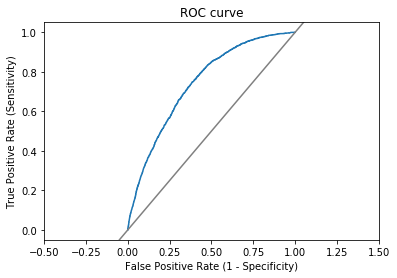

In [19]:
# Task 6 -- drop logLOS and Age, add LOG_Age_Clust                                                              
readmission_clust = readmission.drop(columns=['logLOS','Age'])
readmission_clust['LOS_Age_Clust'] = LOS_Age_Clust

train, test = train_test_split(readmission_clust, stratify=readmission_clust.iloc[:,0],
                               train_size = 0.75, test_size=0.25, random_state = 4321)
form = 'Readmission_Status ~ Gender * Race + ' + " + ".join(set(train.columns) - set(['Readmission_Status']))
print(form)

glmprobit_clust = glm(formula=form, data=train, family=smf.family.Binomial(smf.links.probit())).fit()
print(glmprobit_clust.summary())

predsprobit_clust = glmprobit_clust.predict(test)
fpr, tpr, _ = roc_curve(test['Readmission_Status'], predsprobit_clust)
print(auc(fpr, tpr))
print(confusion_matrix(test['Readmission_Status'], predsprobit_clust > 0.5))
print(classification_report(test['Readmission_Status'], predsprobit_clust > 0.5))
plot_roc(fpr, tpr)


## Task 7

The first step is to binarize the factor levels that have more than two levels. fullRank is set to FALSE so that all levels get binarized. The interaction variable is also a factor variable and must be binarized as well. In each case the base level will then need to be deleted. I do it this way becasue if fullRank is TRUE I can't be sure about which level becomes the base.

```{r}
#Add the interaction variable to the data frame
readmission$RaceGender <- factor(paste0(readmission$Race,readmission$Gender))
summary(readmission$RaceGender)
```

```{r}
factor_names <- c("Race","DRG","RaceGender") 
factor_vars <- readmission[,factor_names]
for (var in factor_names) {
  factor_vars[, var] <- as.character(factor_vars[, var])
}


binarizer <- caret::dummyVars(paste("~", paste(factor_names, collapse = "+")) , data = factor_vars, fullRank = FALSE)
binarized_vars <- data.frame(predict(binarizer, newdata = factor_vars))
head(binarized_vars)

```

In [23]:
# Task 7 binarize                                                                                               
# construct interaction variable by pasting two strings                                                         
c = readmission['Race'].cat
d = readmission['Gender'].cat
readmission['RaceGender'] = (c.categories[c.codes] + d.categories[d.codes]).astype("category")
factor_names = ['Race','DRG','RaceGender']
binarized_vars = pd.get_dummies(readmission[factor_names], prefix_sep='')
print(summary(binarized_vars))

1    56120
0    10656
Name: RaceWhite, dtype: int64

0    59679
1     7097
Name: RaceBlack, dtype: int64

0    64503
1     2273
Name: RaceOthers, dtype: int64

0    65490
1     1286
Name: RaceHispanic, dtype: int64

0    48672
1    18104
Name: DRGMed_C, dtype: int64

0    54466
1    12310
Name: DRGMed_NoC, dtype: int64

0    61419
1     5357
Name: DRGOtherMED, dtype: int64

0    63352
1     3424
Name: DRGOtherSURG, dtype: int64

0    51308
1    15468
Name: DRGSurg_C, dtype: int64

0    55227
1    11549
Name: DRGSurg_NoC, dtype: int64

0    66212
1      564
Name: DRGUNGROUP, dtype: int64

0    62619
1     4157
Name: RaceGenderBlackF, dtype: int64

0    63836
1     2940
Name: RaceGenderBlackM, dtype: int64

0    66025
1      751
Name: RaceGenderHispanicF, dtype: int64

0    66241
1      535
Name: RaceGenderHispanicM, dtype: int64

0    65570
1     1206
Name: RaceGenderOthersF, dtype: int64

0    65709
1     1067
Name: RaceGenderOthersM, dtype: int64

0    34885
1    31891
Name: RaceGende

Now delete the three base variables.

```{r}
binarized_vars$RaceWhite <- NULL
binarized_vars$DRGMed.C <- NULL
binarized_vars$RaceGenderWhiteF <- NULL
head(binarized_vars)
```

I now attach the binarized variables and remove the three original factor variables. A new dataframe is created so the old one is preserved. 

```{r}
readmission.bin <- cbind(readmission,binarized_vars)
readmission.bin$DRG <- NULL
readmission.bin$Race <- NULL
readmission.bin$RaceGender <- NULL
summary(readmission.bin)
```
I need to again split the data into train and test sets.

```{r}
train.bin <- readmission.bin[partition, ]
test.bin <- readmission.bin[-partition, ]
```

I next run the GLM on the binarized data. In doing so, I recognized that the interaction variable created combinations that were redundant. I need to remove all the interactions with male and then re-partition the data.

```{r}
readmission.bin$RaceGenderOthersM <- NULL
readmission.bin$RaceGenderWhiteM <- NULL
readmission.bin$RaceGenderHispanicM <- NULL
readmission.bin$RaceGenderBlackM <- NULL
summary(readmission.bin)
train.bin <- readmission.bin[partition, ]
test.bin <- readmission.bin[-partition, ]
```

In [24]:
binarized_vars = binarized_vars.drop(columns=['RaceWhite','DRGMed_C','RaceGenderWhiteF'])
readmission_bin = pd.concat([readmission, binarized_vars], axis='columns')
readmission_bin = readmission_bin.drop(columns=['DRG','Race','RaceGender'])
readmission_bin = readmission_bin.drop(columns=['RaceGenderOthersM','RaceGenderWhiteM',
                                                'RaceGenderHispanicM','RaceGenderBlackM'])
print(summary(readmission_bin))
train_bin, test_bin = train_test_split(readmission_bin, stratify=readmission.iloc[:,0],
                                       train_size=0.75, test_size=0.25, random_state=4321)


count    66776.000000
mean         0.125928
std          0.331771
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Readmission_Status, dtype: float64

F    38005
M    28771
Name: Gender, dtype: int64

count    66776.000000
mean         0.508296
std          0.817420
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: ER, dtype: float64

count    66776.000000
mean        73.637669
std         13.336339
min         24.000000
25%         67.000000
50%         75.000000
75%         83.000000
max        101.000000
Name: Age, dtype: float64

count    66776.000000
mean         1.652607
std          0.676510
min          0.000000
25%          1.098612
50%          1.609438
75%          2.079442
max          3.583519
Name: logLOS, dtype: float64

count    66776.000000
mean         0.600048
std          0.740757
min         -2.538307
25%          0.101654
50%        

```{r}
glmprobit <- glm(Readmission.Status ~ . , data=train.bin, family = binomial(link="probit"))
summary(glmprobit)
predsprobit <- predict(glmprobit,newdat=test.bin,type="response")
rocprobit <- roc(test.bin$Readmission.Status,predsprobit)
confusionMatrix(factor(1*(predsprobit>.5)),factor(test.bin$Readmission.Status))
plot(rocprobit)
auc(rocprobit)
```

Readmission_Status ~ RaceHispanic + logLOS + RaceBlack + DRGOtherMED + Gender + RaceGenderBlackF + DRGOtherSURG + ER + Age + RaceGenderOthersF + logRiskscore + DRGMed_NoC + DRGSurg_NoC + Under65 + RaceGenderHispanicF + RaceOthers + DRGSurg_C + DRGUNGROUP
                 Generalized Linear Model Regression Results                  
Dep. Variable:     Readmission_Status   No. Observations:                50082
Model:                            GLM   Df Residuals:                    50063
Model Family:                Binomial   Df Model:                           18
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16948.
Date:                Sun, 08 Dec 2019   Deviance:                       33896.
Time:                        00:16:16   Pearson chi2:                 5.30e+04
No. Iterations:                     7                                         
Covariance Type:            nonrob

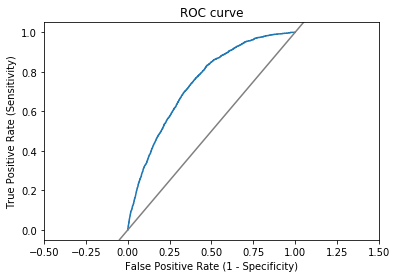

In [26]:
form = 'Readmission_Status ~ ' + " + ".join(set(train_bin.columns) - set(['Readmission_Status']))
print(form)

glmprobit = glm(formula=form, data=train_bin, family=smf.family.Binomial(smf.links.probit())).fit()
print(glmprobit.summary())

predsprobit = glmprobit.predict(test_bin)
fpr, tpr, _ = roc_curve(test_bin['Readmission_Status'], predsprobit)
print(auc(fpr, tpr))
print(confusion_matrix(test_bin['Readmission_Status'], predsprobit > 0.5))
print(classification_report(test_bin['Readmission_Status'], predsprobit > 0.5))
plot_roc(fpr, tpr)

The next step is to run stepAIC on this model.

```{r}
library(MASS)
stepAIC(glmprobit)
```

In [27]:
def stepAIC(ycol, xcols, data, family, link):
    ''' similar to MASS stepAIC '''
    xcols = set(xcols)
    form = ycol + " ~ " + "+".join(xcols)
    best = glm(formula = form, data=data, family=family(link)).fit().aic
    print('Start:   AIC =',best)
    while True:
        aic = []
        for c in xcols:
            form = ycol + " ~ " + " + ".join(xcols - set([c]))
            results = glm(formula=form, data=data, family=family(link)).fit()
            print(c.ljust(20), results.aic)
            aic.append([results.aic, c])
            drop = aic[np.argmin(aic, axis=0)[0]]  # drop is column with lowest aic                             
        if drop[0] > best:
            break
        print('\nDropped:', drop[1].ljust(20),'  AIC =',drop[0],'\n')
        xcols -= set([drop[1]])
        best = drop[0]
    return xcols

cols = set(train_bin.columns) - set(['Readmission_Status'])
best = stepAIC('Readmission_Status', cols, train_bin, smf.family.Binomial, smf.links.probit())
form = "Readmission_Status ~ " + " + ".join(best)
print(form)


Start:   AIC = 33933.91178237095
RaceHispanic         33931.91279384506
logLOS               33939.063245627134
RaceBlack            33933.86927138714
DRGOtherMED          33936.730898515576
Gender               33932.37113699758
RaceGenderBlackF     33933.20053986375
DRGOtherSURG         33935.556170660995
ER                   33931.92705713424
Age                  33953.20950514734
RaceGenderOthersF    33932.1744059081
logRiskscore         37601.246851905096
DRGMed_NoC           33933.66172525715
DRGSurg_NoC          33932.14140444065
Under65              33931.98451746987
RaceGenderHispanicF  33932.11984146045
RaceOthers           33932.04492783824
DRGSurg_C            33931.924326372246
DRGUNGROUP           33931.94112382795

Dropped: RaceHispanic           AIC = 33931.91279384506 

logLOS               33937.06457239029
RaceBlack            33931.87135529234
DRGOtherMED          33934.732212003684
Gender               33930.37296147121
RaceGenderBlackF     33931.20069683672
DRGOth

The probit model is now run using the five surviving variables.

```{r}
glmprobit <- glm(Readmission.Status ~ logLOS + Age + logRiskscore + DRGOtherSURG + DRGOtherMED, data=train.bin, family = binomial(link="probit"))
summary(glmprobit)
predsprobit <- predict(glmprobit,newdat=test.bin,type="response")
rocprobit <- roc(test.bin$Readmission.Status,predsprobit)
confusionMatrix(factor(1*(predsprobit>.5)),factor(test.bin$Readmission.Status))
plot(rocprobit)
auc(rocprobit)
```

                 Generalized Linear Model Regression Results                  
Dep. Variable:     Readmission_Status   No. Observations:                50082
Model:                            GLM   Df Residuals:                    50076
Model Family:                Binomial   Df Model:                            5
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16951.
Date:                Sun, 08 Dec 2019   Deviance:                       33902.
Time:                        00:21:21   Pearson chi2:                 5.31e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.4756      0.047    -31.411   

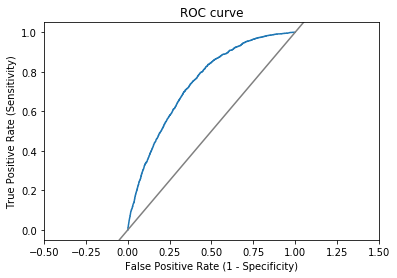

In [29]:
glmprobit = glm(formula=form, data=train_bin, family=smf.family.Binomial(smf.links.probit())).fit()
print(glmprobit.summary())

predsprobit = glmprobit.predict(test_bin)
fpr, tpr, _ = roc_curve(test_bin['Readmission_Status'], predsprobit)
print(auc(fpr, tpr))
print(confusion_matrix(test_bin['Readmission_Status'], predsprobit > 0.5))
print(classification_report(test_bin['Readmission_Status'], predsprobit > 0.5))
plot_roc(fpr, tpr)

## Task 8

I first run the model on the full dataset.


```{r}
glmprobit <- glm(Readmission.Status ~ logLOS + Age + logRiskscore + DRGOtherSURG + DRGOtherMED, data=readmission.bin, family = binomial(link="probit"))

summary(glmprobit)
```
I now create some arbitrary patients to learn how changing the values affects the predicted probability of readmission.

```{r}
new.data <- data.frame("logLOS" = c(log(5),log(6),log(5),log(5),log(5),log(5)), "Age" = c(75,75,80,75,75,75), "logRiskscore" = c(log(1.866),log(1.866),log(1.866),log(2.053),log(1.866),log(1.866)), "DRGOtherSURG" = c(0,0,0,0,1,0), "DRGOtherMED" = c(0,0,0,0,0,1))
new.data
predict(glmprobit, newdat = new.data, type = "response")
```

In [30]:
# Task 8: Now fit on full sample, and test on arbitrary patients                                                
glmprobit = glm(formula=form, data=readmission_bin, family=smf.family.Binomial(smf.links.probit())).fit()
print(glmprobit.summary())

new_data = DataFrame({"logLOS" : np.log([5,6,5,5,5,5]),
                      "Age" : [75,75,80,75,75,75],
                      "logRiskscore" : np.log([1.866,1.866,1.866,2.053,1.866,1.866]),
                      "DRGOtherSURG" : [0,0,0,0,1,0],
                      "DRGOtherMED" : [0,0,0,0,0,1]})
print(new_data)
print(glmprobit.predict(new_data))


                 Generalized Linear Model Regression Results                  
Dep. Variable:     Readmission_Status   No. Observations:                66776
Model:                            GLM   Df Residuals:                    66770
Model Family:                Binomial   Df Model:                            5
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22558.
Date:                Sun, 08 Dec 2019   Deviance:                       45116.
Time:                        00:24:35   Pearson chi2:                 7.09e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.5026      0.041    -36.871   

## Task 9 

I rerun the model on the full dataset.

```{r}

glmprobit <- glm(Readmission.Status ~ logLOS + Age + logRiskscore + DRGOtherSURG + DRGOtherMED, data=readmission.bin, family = binomial(link="probit"))

summary(glmprobit)

predsprobit <- predict(glmprobit,newdat=readmission.bin,type="response")


confusionMatrix(factor(1*(predsprobit>.5)),factor(readmission.bin$Readmission.Status))

```

In [31]:
# Task 9: Now fit and predict on whole dataset, with cutoff > 0.08                                              
predsprobit = glmprobit.predict(readmission_bin)
fpr, tpr, _ = roc_curve(readmission_bin['Readmission_Status'], predsprobit)
print(auc(fpr, tpr))
print(confusion_matrix(readmission_bin['Readmission_Status'], predsprobit > 0.5))
print(classification_report(readmission_bin['Readmission_Status'], predsprobit > 0.5))


0.7383367446156447
[[58356    11]
 [ 8399    10]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     58367
           1       0.48      0.00      0.00      8409

    accuracy                           0.87     66776
   macro avg       0.68      0.50      0.47     66776
weighted avg       0.82      0.87      0.82     66776



This code calculates the cost for different cutoff values. I ran it at different values and am presting the final choice of 0.08.

```{r}

cutoff <- 0.08
pred_readmit <- 1*(predsprobit > cutoff)
cm <- confusionMatrix(factor(pred_readmit),factor(readmission.bin$Readmission.Status))

no_intervention_cost <- 25*sum(readmission.bin$Readmission.Status == 1)
full_intervention_cost <- 2*nrow(readmission.bin)
modified_cost <- cm$table[2,1]*2+cm$table[2,2]*2+cm$table[1,2]*25
no_intervention_cost
full_intervention_cost
modified_cost

```

In [32]:
cutoff = 0.08
cm = confusion_matrix(readmission_bin['Readmission_Status'], predsprobit  > cutoff)
no_intervention_cost =  25 * sum(readmission_bin['Readmission_Status'] == 1)
full_intervention_cost = 2 * len(readmission_bin)
modified_cost = cm[0,1] * 2 + cm[1,1] * 2 + cm[1,0] * 25
print([no_intervention_cost, full_intervention_cost, modified_cost])


[210225, 133552, 106002]
